# Education Project
**Problem Statement:** Prediction of school performance by Socio-economic factors.

**Author:** Raja Sandeep Mukkala

**Affiliation:** Seattle University

**Course:** DATA-5100 Foundation of Data Science

**Professor:** Dr. Brian Fischer

**Date:** October 22, 2025

**Introduction:**

- Here we are predicting the performance of school which is a measure of average ACT score by using different socio-economic factors. We start linear regression , quadratic regression and then finaly we use multiple linear regression model and we will compare all the three.
- In Multiple linear regression model we will be using two new predictors student and teacher ratio(`student_teacher_ratio`) in each school and percentage of internet access across households in each state(`percent_internet_access`) along with the already disscussed predictors in the class room.

- We are using Python libraries like Pandas, sklearn, statsmodels, Matplotlib, Numpy and Seaborn for visualization and analysis purpose and requests for calling and getting response from API to load Internet access Information across different states.

**Data Source:**

- **Source:**
    - [EdGap data](https://github.com/brian-fischer/DATA-5100/blob/main/EdGap_data.xlsx)
    - [School Information data](https://www.dropbox.com/scl/fi/fkafjk8902sq8ptxh94r2/ccd_sch_029_1617_w_1a_11212017.csv?rlkey=gucrdz5f6e38bezz2y3yalxbw&e=1&dl=0)
    - [Student Information data](https://nces.ed.gov/ccd/pubschuniv.asp)
    - [Staff Information data](https://nces.ed.gov/ccd/pubschuniv.asp)
    - [Internet Access Information data](https://api.census.gov/data/2017/acs/acs5/profile?get=NAME,DP02_0152PE&for=state:*)
- **Description:**
    - The data in these datasets is from (2016-2017) year.
    - EdGap dataset: A socioeconomic data which contains NCESSCH School ID, CT Unemployment Rate, CT Pct Adults with College Degree, CT Pct Children In Married Couple Family, CT Median Household Income and School ACT average and is downloaded from the Census Bureau’s American Community Survey. It contains 7987 rows and 7 features in csv format.

    - School Information dataset: The school information data is from the National Center for Education Statistics. This data set consists of basic identifying information about schools like SCHOOL_YEAR, STATENAME, SCH_NAME, NCESSCH, LSTATE, LZIP, SCH_TYPE_TEXT, LEVEL, CHARTER_TEXT. It contains 102182 rows and 65 features in csv format.
    
    - Student Information dataset: This dataset provides information about the the number students in each grade accross different schools in USA. It contains 12279594 rows and 18 features(SCHOOL_YEAR,FIPST,STATENAME ,ST,SCH_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,ST_SCHID,NCESSCH,SCHID,GRADE,RACE_ETHNICITY,SEX,STUDENT_COUNT,TOTAL_INDICATOR,DMS_FLAG)
    
    - Staff Information dataset: This dataset provides information about the number of teachers for each grade across different schools in USA. It contains 100063 rows and 15 features(SCHOOL_YEAR,FIPST,STATENAME,ST,SCH_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,ST_SCHID,NCESSCH,SCHID,TEACHERS,TOTAL_INDICATOR,DMS_FLAG) in csv format.
    
    - Internet Access Information dataset: This dataset contains percent estimate of total households with a broadband internet subscription in each state, it contains the state, percent estimate of total households with a broadband internet subscription in that state(DP02_0152PE). DP02_0152PE: Percent Estimate of total households with a broadband Internet subscription

### 1. Import Libraries:

In [61]:
import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm

# set the plotting style
sns.set_style("whitegrid")

### 2. Load Data:

In [62]:
# Load the datasets
try:
    edgap = pd.read_excel(
        '../data/EdGap_data.xlsx', dtype={'NCESSCH School ID': object}
    )
except FileNotFoundError:
    print("Error: EdGap_data.xlsx not found. Please ensure the file is in the correct directory.")
    edgap = None # Assign None or handle as appropriate

try:
    school_information = pd.read_csv(
        '../data/ccd_sch_029_1617_w_1a_11212017.csv',
        encoding='unicode_escape',
        low_memory=False # Add low_memory=False to handle mixed types
    )
except FileNotFoundError:
     print("Error: ccd_sch_029_1617_w_1a_11212017.csv not found. Please ensure the file is in the correct directory.")
     school_information = None # Assign None or handle as appropriate

# Student and Staff Information Data
# NCES CCD (2016–17)
try:
    student_information = pd.read_csv(
        '../data/ccd_sch_052_1617_l_2a_11212017.csv',
        encoding='unicode_escape',
    )
except FileNotFoundError:
    print("Error: ccd_sch_052_1617_l_2a_11212017.csv not found. Please ensure the file is in the correct directory.")
    student_information = None # Assign None or handle as appropriate

try:
    staff_information = pd.read_csv(
        '../data/ccd_sch_059_1617_l_2a_11212017.csv',
        encoding='unicode_escape',
    )
except FileNotFoundError:
    print("Error: ccd_sch_059_1617_l_2a_11212017.csv not found. Please ensure the file is in the correct directory.")
    staff_information = None # Assign None or handle as appropriate


# ACS 2017 5-year Data Profile (Census API)
api_url = (
    "https://api.census.gov/data/2017/acs/acs5/profile?"
    "get=NAME,DP02_0152PE&for=state:*"
)
try:
    response = requests.get(api_url)
    response.raise_for_status() # Raise an exception for bad status codes
    internet_access_information = pd.read_json(api_url)
except requests.exceptions.RequestException as e:
    print(f"Error fetching data from Census API: {e}")
    internet_access_information = None # Assign None or handle as appropriate


# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
# Disable line wrapping for better readability
pd.set_option('display.width', None)

- Loaded the `Edgap`, `School information`, `Student information`, `Staff information` from csv files in data folder.
- Made a GET request using the url 'https://api.census.gov/data/2017/acs/acs5/profile?get=NAME,DP02_0152PE&for=state:*' to download `Internet Access information` from the census.gov website.

### 3. Displaying `head` and `info` for the datasets:
- Displaying `head` and `info` for `edgap`, `school_information`, `student_information`, `staff_information` and `internet_access_information` to inspect schema, confirm the data availability

In [63]:
print("EdGap data:")
print(edgap.head())
print("\nEdGap data info:")
print(edgap.info())

print("\nSchool information data:")
print(school_information.head())
print("\nSchool information data info:")
print(school_information.info())

print("\nStudent information data:")
print(student_information.head())
print("\nStudent information data info:")
print(student_information.info())

print("\nStaff information data:")
print(staff_information.head())
print("\nStaff information data info:")
print(staff_information.info())

print("\nInternet access data:")
print(internet_access_information.head())
print("\nInternet access data info:")
print(internet_access_information.info())

EdGap data:
  NCESSCH School ID  CT Unemployment Rate  CT Pct Adults with College Degree  \
0      100001600143              0.117962                           0.445283   
1      100008000024              0.063984                           0.662765   
2      100008000225              0.056460                           0.701864   
3      100017000029              0.044739                           0.692062   
4      100018000040              0.077014                           0.640060   

   CT Pct Childre In Married Couple Family  CT Median Household Income  \
0                                 0.346495                     42820.0   
1                                 0.767619                     89320.0   
2                                 0.713090                     84140.0   
3                                 0.641283                     56500.0   
4                                 0.834402                     54015.0   

   School ACT average (or equivalent if SAT score)  \
0       

- Succesfully loaded the data into dataframes.
- There are missing values in the `edgap` dataFrame in the following columns CT Unemployment, CT Pct Adults with College Degree, CT Pct Childr In Married Couple Family, CT Median Household Income.
- There are missing values in the dataframe `school_information` under columns like CHARTER_TEXT, LEVEL etc.,
- There are missing values in the dataframe ``staff_information` under columns like TEACHERS etc.,

### 4 . Exploratory Data Analysis 
4.1 Pair Plot to explore relationship between variables in `edgap` dataset:

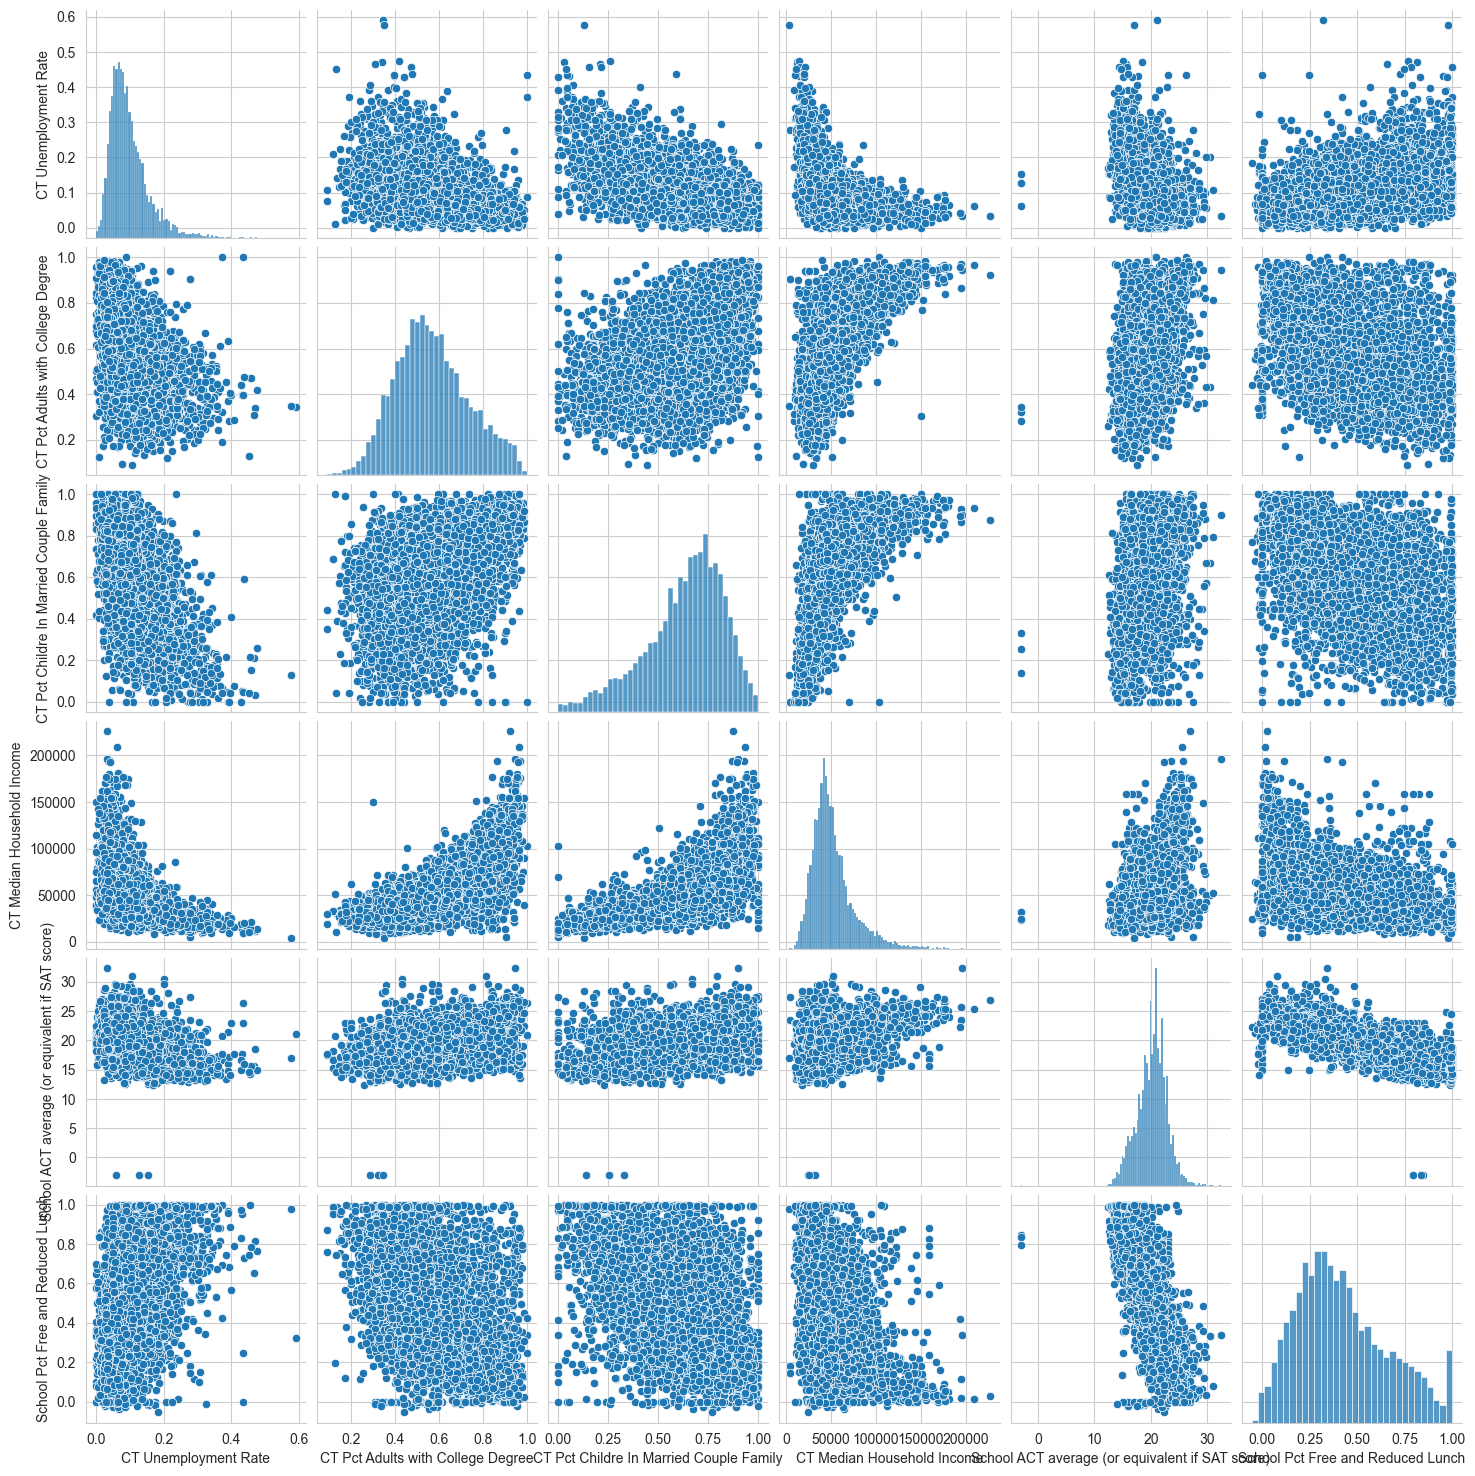

In [64]:
sns.pairplot(edgap.drop(columns='NCESSCH School ID'))
plt.show()

**Interpretation:**

It plots all pairwise numeric relationships in dataset.

- ACT average vs CT Unemployment Rate:
  - Unemployment rate increases, ACT average decreases - negative correlation

- ACT average vs CT Median Household Income:
  - House hold income increases, ACT average increases  - positive correlation

- ACT average vs CT Pct Adult College Degree:
    - CT Pct Adult College Degree increases, ACT average increases - positive coreelation

- ACT average vs CT Pct Children in Married Couple Family:
    - CT Pct Children in Married Couple Family increases, slight increase in ACT average - mild positive correlation

- ACT average vs Pct Free ans Reduced Lunch:
    - Pct Free ans Reduced Lunch increases, ACT average decreases - negative correlation.

4.2. Adding regression lines to Pair plot of `edgap` dataset:

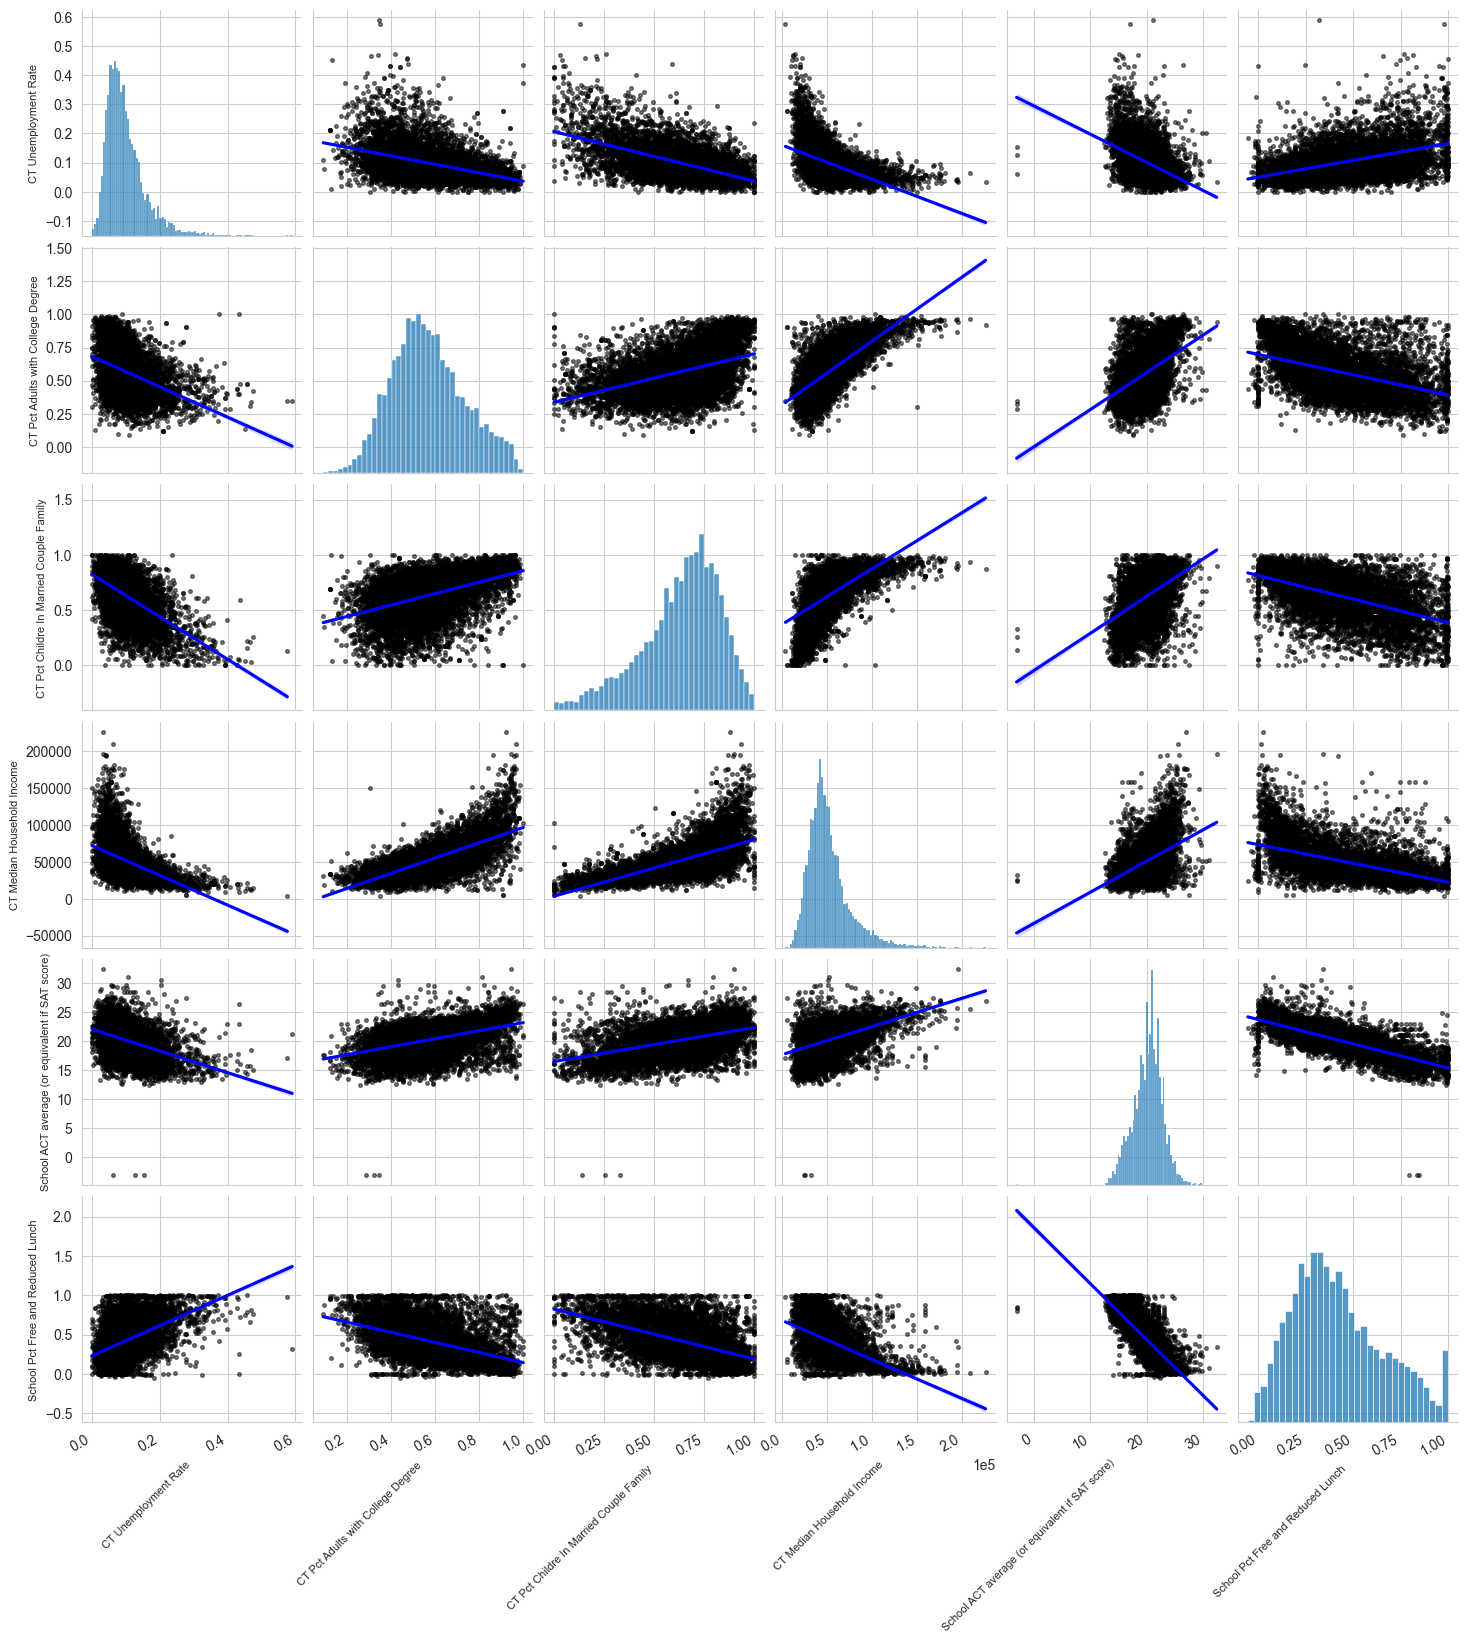

In [65]:
fig = sns.pairplot(
    edgap.drop(columns='NCESSCH School ID'),
    kind='reg',
    plot_kws={
        'line_kws': {'color': 'blue'},
        'scatter_kws': {'alpha': 0.5, 'color': 'k', 's': 7},
    },
)

# Create a dictionary for more concise plotting labels
plot_labels = {
    'percent_college': 'Pct Adults with College Degree',
    'rate_unemployment': 'Unemployment Rate',
    'percent_married': 'Pct Children in Married Couple Family',
    'median_income': 'Median Household Income',
    'percent_lunch': 'Pct Free and Reduced Lunch',
    'student_teacher_ratio': 'Student Teacher Ratio',
    'percent_internet_access': 'Pct Internet Access',
    'average_act': 'Average ACT Score',
}

for ax in fig.axes.flat:
    # Use the plot_labels dictionary for more concise labels
    xlabel = ax.get_xlabel()
    if xlabel in plot_labels:
        ax.set_xlabel(plot_labels[xlabel], fontsize=8, rotation=45, ha='right')
    else:
        ax.set_xlabel(xlabel, fontsize=8, rotation=45, ha='right')

    ylabel = ax.get_ylabel()
    if ylabel in plot_labels:
        ax.set_ylabel(plot_labels[ylabel], fontsize=8)
    else:
        ax.set_ylabel(ylabel, fontsize=8)

    if xlabel == 'CT Median Household Income': # Still use original name for this check
        ax.ticklabel_format(
            style='sci', axis='x', scilimits=(0, 0)
        )  # Apply scientific notation


    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

4.3 Ploting single row since we are intereted on schools average ACT vs other variables in `edgap` dataset:

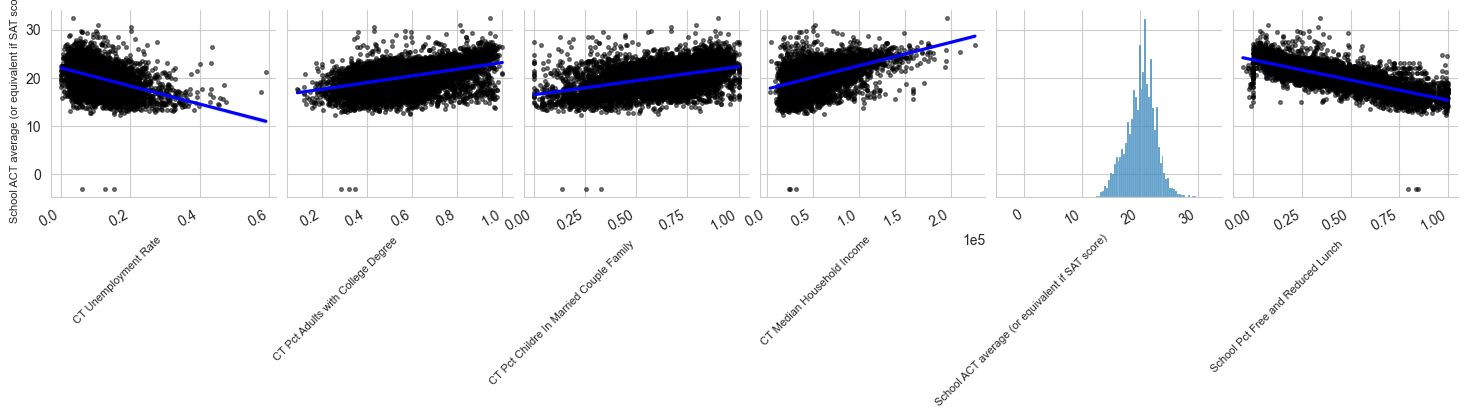

In [66]:
fig = sns.pairplot(
    edgap.drop(columns='NCESSCH School ID'),
    y_vars=['School ACT average (or equivalent if SAT score)'],
    kind='reg',
    plot_kws={
        'line_kws': {'color': 'blue'},
        'scatter_kws': {'alpha': 0.5, 'color': 'k', 's': 7},
    },
)

for ax in fig.axes.flat:
    # Use the plot_labels dictionary for more concise labels
    xlabel = ax.get_xlabel()
    if xlabel in plot_labels:
        ax.set_xlabel(plot_labels[xlabel], fontsize=8, rotation=45, ha='right')
    else:
        ax.set_xlabel(xlabel, fontsize=8, rotation=45, ha='right')

    ylabel = ax.get_ylabel()
    if ylabel in plot_labels:
        ax.set_ylabel(plot_labels[ylabel], fontsize=8)
    else:
        ax.set_ylabel(ylabel, fontsize=8)

    if xlabel == 'CT Median Household Income': # Still use original name for this check
        ax.ticklabel_format(
            style='sci', axis='x', scilimits=(0, 0)
        )  # Apply scientific notation

    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

**Interpretation:**

- ACT average vs CT Unemployment Rate:
  - Unemployment rate increases, ACT average decreases - negative correlation

- ACT average vs CT Median Household Income:
  - House hold income increases, ACT average increases  - positive correlation

- ACT average vs CT Pct Adult College Degree:
    - CT Pct Adult College Degree increases, ACT average increases - positive coreelation

- ACT average vs CT Pct Children in Married Couple Family:
    - CT Pct Children in Married Couple Family increases, slight increase in ACT average - mild positive correlation

- ACT average vs Pct Free ans Reduced Lunch:
    - Pct Free ans Reduced Lunch increases, ACT average decreases - negative correlation.

### 5 Data Preparation:
- 5.1. Counting total students in each `NCESSCH id` in student information dataset:

In [67]:
# Select relevant columns from student information data
student_information = student_information[['NCESSCH', 'STUDENT_COUNT']]
# Convert student count to numeric, coercing errors to NaN and filling NaN with 0
# Assumption: Missing student counts indicate zero students.
student_information['STUDENT_COUNT'] = (
    pd.to_numeric(student_information['STUDENT_COUNT'], errors='coerce')
    .fillna(0)
)

# Group by school ID and sum student counts
student_information = student_information.groupby(['NCESSCH'], as_index=False).agg(
    {'STUDENT_COUNT': 'sum'}
)

print("\nStudent counts by level:")
print(student_information.head())


Student counts by level:
       NCESSCH  STUDENT_COUNT
0  10000200277            0.0
1  10000201667            0.0
2  10000201670            0.0
3  10000201705            0.0
4  10000201706            0.0


- We need to compute the `student and teacher ratio` since we are using it as a predictor variable so therefore we need to count the `number of students` by `NCESSCH Id` in Student Information dadatset to compute it

- 5.2 Selecting required columns from school information, staff information and internet access information datasets:

In [68]:
school_information = school_information[[
    'SCHOOL_YEAR',
    'NCESSCH',
    'LSTATE',
    'LZIP',
    'SCH_TYPE_TEXT',
    'LEVEL',
    'CHARTER_TEXT',
]]
print("\nSchool information data:")
print(school_information.head())

staff_information = staff_information[['NCESSCH', 'TEACHERS']]
print("\nStaff information data:")
print(staff_information.head())

internet_access_information = internet_access_information[[0, 1]]
print("\nInternet access information data:")
print(internet_access_information.head())


School information data:
  SCHOOL_YEAR       NCESSCH LSTATE   LZIP       SCH_TYPE_TEXT LEVEL  \
0   2016-2017  1.000020e+10     AL  35220  Alternative School  High   
1   2016-2017  1.000020e+10     AL  36067  Alternative School  High   
2   2016-2017  1.000020e+10     AL  36784  Alternative School  High   
3   2016-2017  1.000020e+10     AL  36057  Alternative School  High   
4   2016-2017  1.000020e+10     AL  35206  Alternative School  High   

  CHARTER_TEXT  
0           No  
1           No  
2           No  
3           No  
4           No  

Staff information data:
       NCESSCH  TEACHERS
0  10000200277       0.0
1  10000201667       0.0
2  10000201670       0.0
3  10000201705       0.0
4  10000201706       0.0

Internet access information data:
             0            1
0         NAME  DP02_0152PE
1  Mississippi         64.3
2     Missouri         75.0
3      Montana         76.1
4     Nebraska         78.5


- Selecting only the required columns i.e `SCHOOL_YEAR`, `NCESSCH`,`LSTATE`, `LZIP`,`SCH_TYPE_TEXT`, `LEVEL`, `CHARTER_TEXT` from school information dataset.
- Selecting only the required columns i.e `NCESSCH`, `TEACHERS` from staff information dataset
- Selecting only the required columns i.e `State` and `Percent of internet coverage among available households with in each state` from internet_access_information dataset.

- 5.3 Renaming Columns and converting state names to its abbrevations across datasets to maintain uniformity:

In [69]:
# Rename columns for clarity and consistency
edgap = edgap.rename(
    columns={
        'NCESSCH School ID': 'id',
        'CT Pct Adults with College Degree': 'percent_college',
        'CT Unemployment Rate': 'rate_unemployment',
        'CT Pct Childre In Married Couple Family': 'percent_married',
        'CT Median Household Income': 'median_income',
        'School ACT average (or equivalent if SAT score)': 'average_act',
        'School Pct Free and Reduced Lunch': 'percent_lunch',
    }
)

school_information = school_information.rename(
    columns={
        'SCHOOL_YEAR': 'year',
        'NCESSCH': 'id',
        'LSTATE': 'state',
        'LZIP': 'zip_code',
        'SCH_TYPE_TEXT': 'school_type',
        'LEVEL': 'school_level',
        'CHARTER_TEXT': 'charter',
    }
)
student_information = student_information.rename(
    columns={'NCESSCH': 'id', 'STUDENT_COUNT': 'student_count'}
)
staff_information = staff_information.rename(
    columns={'NCESSCH': 'id', 'TEACHERS': 'teacher_count'}
)
internet_access_information = internet_access_information.rename(
    columns={0: 'state', 1: 'percent_internet_access'}
)

# Remove the first row which contains column names
internet_access_information = internet_access_information.iloc[1:]
internet_access_information['percent_internet_access'] = (
    pd.to_numeric(internet_access_information['percent_internet_access'], errors='coerce')
    .fillna(0)
)

# Convert percentage to proportion
internet_access_information['percent_internet_access'] = (
    internet_access_information['percent_internet_access'] / 100.0
)

# Dictionary to map state names to abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District of Columbia': 'DC',
}

# Converting state names to its abbrevations
internet_access_information['state'] = internet_access_information['state'].map(
    us_state_abbrev
)

print("\nEdGap data:")
print(edgap.head())
print("\nSchool information data:")
print(school_information.head())
print("\nStudent information data:")
print(student_information.head())
print("\nStaff information data:")
print(staff_information.head())
print("\nInternet access data:")
print(internet_access_information.head())


EdGap data:
             id  rate_unemployment  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  average_act  percent_lunch  
0        42820.0    20.433455       0.066901  
1        89320.0    19.498168       0.112412  
2        84140.0    19.554335       0.096816  
3        56500.0    17.737485       0.296960  
4        54015.0    18.245421       0.262641  

School information data:
        year            id state zip_code         school_type school_level  \
0  2016-2017  1.000020e+10    AL    35220  Alternative School         High   
1  2016-2017  1.000020e+10    AL    36067  Alternative School         High   
2  2016-2017

- Renaming Columns in the `edgap`, `school information`, `student information`, `staff information`, `internet access information` datasets.
- Converting state names to its abbrevations in `internet access information` dataset to maintain uniformity.

- 5.4 Joining datasets and adding `student_teacher_ratio` as a column for each NCESSCH id onto merged dataset:

In [70]:
# Ensure 'id' columns are object type for consistent merging
school_information['id'] = school_information['id'].astype(object)
student_information['id'] = student_information['id'].astype(object)
staff_information['id'] = staff_information['id'].astype(object)
# Ensure 'percent_internet_access' is float type
internet_access_information['percent_internet_access'] = internet_access_information[
    'percent_internet_access'
].astype(float)

# Merging the datasets using left merges to keep all rows from edgap
merged_data = (
    edgap.merge(school_information, how='left', on='id')
    .merge(student_information, how='left', on='id')
    .merge(staff_information, how='left', on='id')
    .merge(internet_access_information, how='left', on='state')
)


# Computing the students count and teachers count for each NCESSCH id for ratio calculation
student_teacher_stats = merged_data.groupby('id', as_index=False).agg({
    'student_count': 'sum',
    'teacher_count': 'sum',
})

# Computing the student teacher ratio, handling division by zero
merged_data['student_teacher_ratio'] = np.where(
    student_teacher_stats['teacher_count'] > 0,
    student_teacher_stats['student_count'] / student_teacher_stats['teacher_count'],
    np.nan, # Assign NaN if teacher count is zero to avoid errors
)

print("Merged data:")
print(merged_data.head())
print("\nMerged data info:")
print(merged_data.info())

Merged data:
             id  rate_unemployment  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  average_act  percent_lunch       year state zip_code  \
0        42820.0    20.433455       0.066901  2016-2017    DE    19804   
1        89320.0    19.498168       0.112412  2016-2017    DE    19709   
2        84140.0    19.554335       0.096816  2016-2017    DE    19709   
3        56500.0    17.737485       0.296960  2016-2017    DE    19958   
4        54015.0    18.245421       0.262641  2016-2017    DE    19934   

      school_type school_level charter  student_count  teacher_count  \
0  Regular School         High     Ye

- We need to join the dataframes on the basis of identity of the school therefore we are type casting `identity of school` column in `school_information`, `student_information`, `staff_information`  dataframes to `object` since it is in `float64`.
- And we are type casting the `object` type to `float` for `percent_internet_access` column as it holds percentage information.
- Left joining the dataframes `EdGap`, `school_information`, `student_information`, `staff_information` and `internet_access_information` to merge on id.

### 6. Quality Control:


In [71]:
# Checking the minimum and maximum values in each column
print("Minimum and Maximum values: ")
print(merged_data.select_dtypes(include=['number']).agg(['min', 'max']).round(2))

# Setting out of range values to NaN using np.nan
merged_data.loc[merged_data['percent_lunch'] < 0, 'percent_lunch'] = np.nan
merged_data.loc[merged_data['average_act'] < 1, 'average_act'] = np.nan

# Checking the types, level and charter status of school
print("\nType: ")
print(merged_data['school_type'].value_counts())

# Checking the school level
print("\nLevel: ")
print(merged_data['school_level'].value_counts())

# Checking the charter status
print("\nCharter status: ")
print(merged_data['charter'].value_counts())

# Filtering data for High school level
merged_data_school_level_high = merged_data.loc[merged_data['school_level'] == 'High']

print("\nData after filtering for High school level:")
print(merged_data_school_level_high.head())

Minimum and Maximum values: 
     rate_unemployment  percent_college  percent_married  median_income  \
min               0.00             0.09              0.0         3589.0   
max               0.59             1.00              1.0       226181.0   

     average_act  percent_lunch  student_count  teacher_count  \
min        -3.07          -0.05            0.0            0.0   
max        32.36           1.00        60165.0          570.1   

     percent_internet_access  student_teacher_ratio  
min                     0.00                    0.0  
max                     0.84                32960.0  

Type: 
school_type
Regular School                 7885
Alternative School               10
Special Education School          2
Career and Technical School       1
Name: count, dtype: int64

Level: 
school_level
High            7230
Other            631
Not reported      35
Elementary         2
Name: count, dtype: int64

Charter status: 
charter
No                7329
Yes             

- Checked variable ranges, replaced negative values in precent_lunch and average_act values less than 1 with `NaN`, summarized school type/level/charter distributions, and filtered data to include only high schools.
- The data set has more regular schools compared to alternative, special education, career and technical schools and more high schools compared to other other/Not reported/Elementary schools.
- We are only taking high school records from the dataset.

- Checking for duplicates and missing values:

In [72]:
# Duplicate check
print("Duplicates: ")
print(merged_data_school_level_high.duplicated().sum())

# Identify missing values
print("\nMissing values: ")
print(merged_data_school_level_high.isna().sum().to_frame(name='Number of Missing Values'))

percent_missing = merged_data_school_level_high.isna().mean().round(4) * 100
print("\nPercentage of missing values: ")
print(percent_missing.to_frame(name='Percent Missing Values'))

Duplicates: 
0

Missing values: 
                         Number of Missing Values
id                                              0
rate_unemployment                              12
percent_college                                11
percent_married                                20
median_income                                  16
average_act                                     3
percent_lunch                                  20
year                                            0
state                                           0
zip_code                                        0
school_type                                     0
school_level                                    0
charter                                         0
student_count                                   0
teacher_count                                   9
percent_internet_access                         0
student_teacher_ratio                          14

Percentage of missing values: 
                         Percent Mi

- No duplicates in the dataset.
- Some of the columns in the dataset has missing values like reate_unemployment, percent_lunch etc., which suggest that we need to do data handling for missing values.

In [73]:
# Drop rows where average ACT score is missing
merged_data_school_level_high = merged_data_school_level_high.dropna(
    subset=['average_act']
)
merged_data_school_level_high.drop(['student_count', 'teacher_count'], axis=1, inplace=True)

- As our main focus of analysis is on `average act` therefore we dont consider data that dont have `average act` values.
- Hence droping the rows for  missing `average ACT scores.
- dropped the `student_count` and `teacher_count` column which are not required as we already computed `student_teacher_ratio`.

### 7. Data imputation:

In [74]:
# Predictor variables are defined that needs to be imputed
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter',
    'student_teacher_ratio',
    'percent_internet_access',
]

# Initialize IterativeImputer for imputing missing numerical values
imputer = IterativeImputer()

# Defining the columns to use in the imputation process (selecting only numerical predictors)
numerical_predictors = merged_data_school_level_high[
    predictor_variables
].select_dtypes(include=['number']).columns.to_list()
print(numerical_predictors)

# Fiting the imputer using numerical predictor variables from the filtered data
imputer.fit(merged_data_school_level_high.loc[:, numerical_predictors])

# impute the missing values in the filtered data
merged_data_school_level_high.loc[:, numerical_predictors] = imputer.transform(
    merged_data_school_level_high.loc[:, numerical_predictors]
)

# Checking the missing values after imputation
print(
    merged_data_school_level_high.isna()
    .sum()
    .to_frame(name='Number of Missing Values')
)

# Define the output directory and create it if it doesn't exist
output_dir = '../data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saving the cleaned dataset in csv format inside the data folder
merged_data_school_level_high.to_csv(
    os.path.join(output_dir, 'cleaned_education_data.csv'), encoding='utf-8-sig', index=False
)

print("\nDataset Head after imputation:")
print(merged_data_school_level_high.head())

['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'student_teacher_ratio', 'percent_internet_access']
                         Number of Missing Values
id                                              0
rate_unemployment                               0
percent_college                                 0
percent_married                                 0
median_income                                   0
average_act                                     0
percent_lunch                                   0
year                                            0
state                                           0
zip_code                                        0
school_type                                     0
school_level                                    0
charter                                         0
percent_internet_access                         0
student_teacher_ratio                           0

Dataset Head after imputation:
             id  rate_

- Missing values are imputed for numeric predictors using iterative model


### 8. Visualization:
- 8.1 Heat Map:
    - The heatmap displays the correlation between average_act and other variables

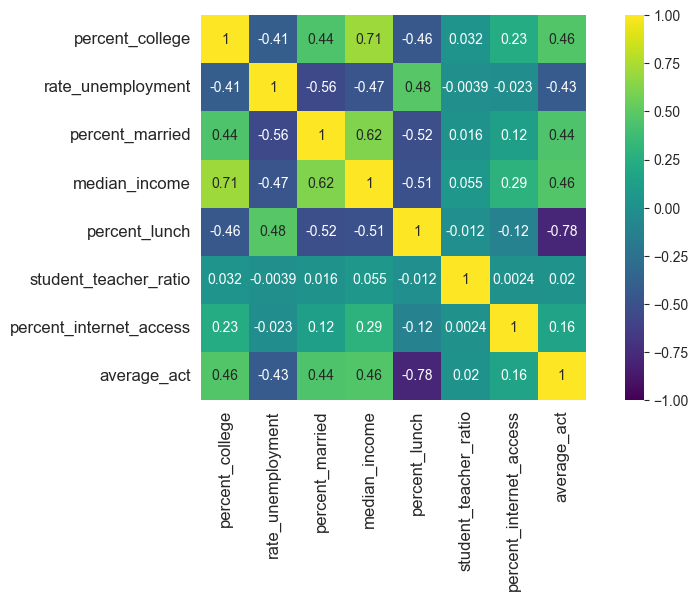

In [75]:
predictors = [
    'percent_college',
    'rate_unemployment',
    'percent_married',
    'median_income',
    'percent_lunch',
    'student_teacher_ratio',
    'percent_internet_access',
]
numerical_predictors = merged_data_school_level_high[predictors].select_dtypes(
    include=['number']
).columns.to_list()
corr_matrix = merged_data_school_level_high[
    numerical_predictors + ["average_act"]
].corr()

plt.figure(figsize=(10, 5))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)
plt.tick_params(labelsize=12)
plt.show()

**Interpretation:**

- `percent_lunch` shows strong negative correlation with ``average_act`
    - Schools with more low income students have low low ACT scores.
- `median_income`, `percent_college` have positive correlation with ACT scores.
    - Schools that are around high income and better educated population has good ACT scores.
- `student_teacher_ratio`, `percent_internet_access` have some positive correlation.
- `rate_unemployment` is negatively correlated, which means higher un employment rate lead to lower ACT scores.

- 8.2 Pair Plot:
    - Pair plt to visualize relationship between numerical predictors and average ACT scores by charter and non charter schools.

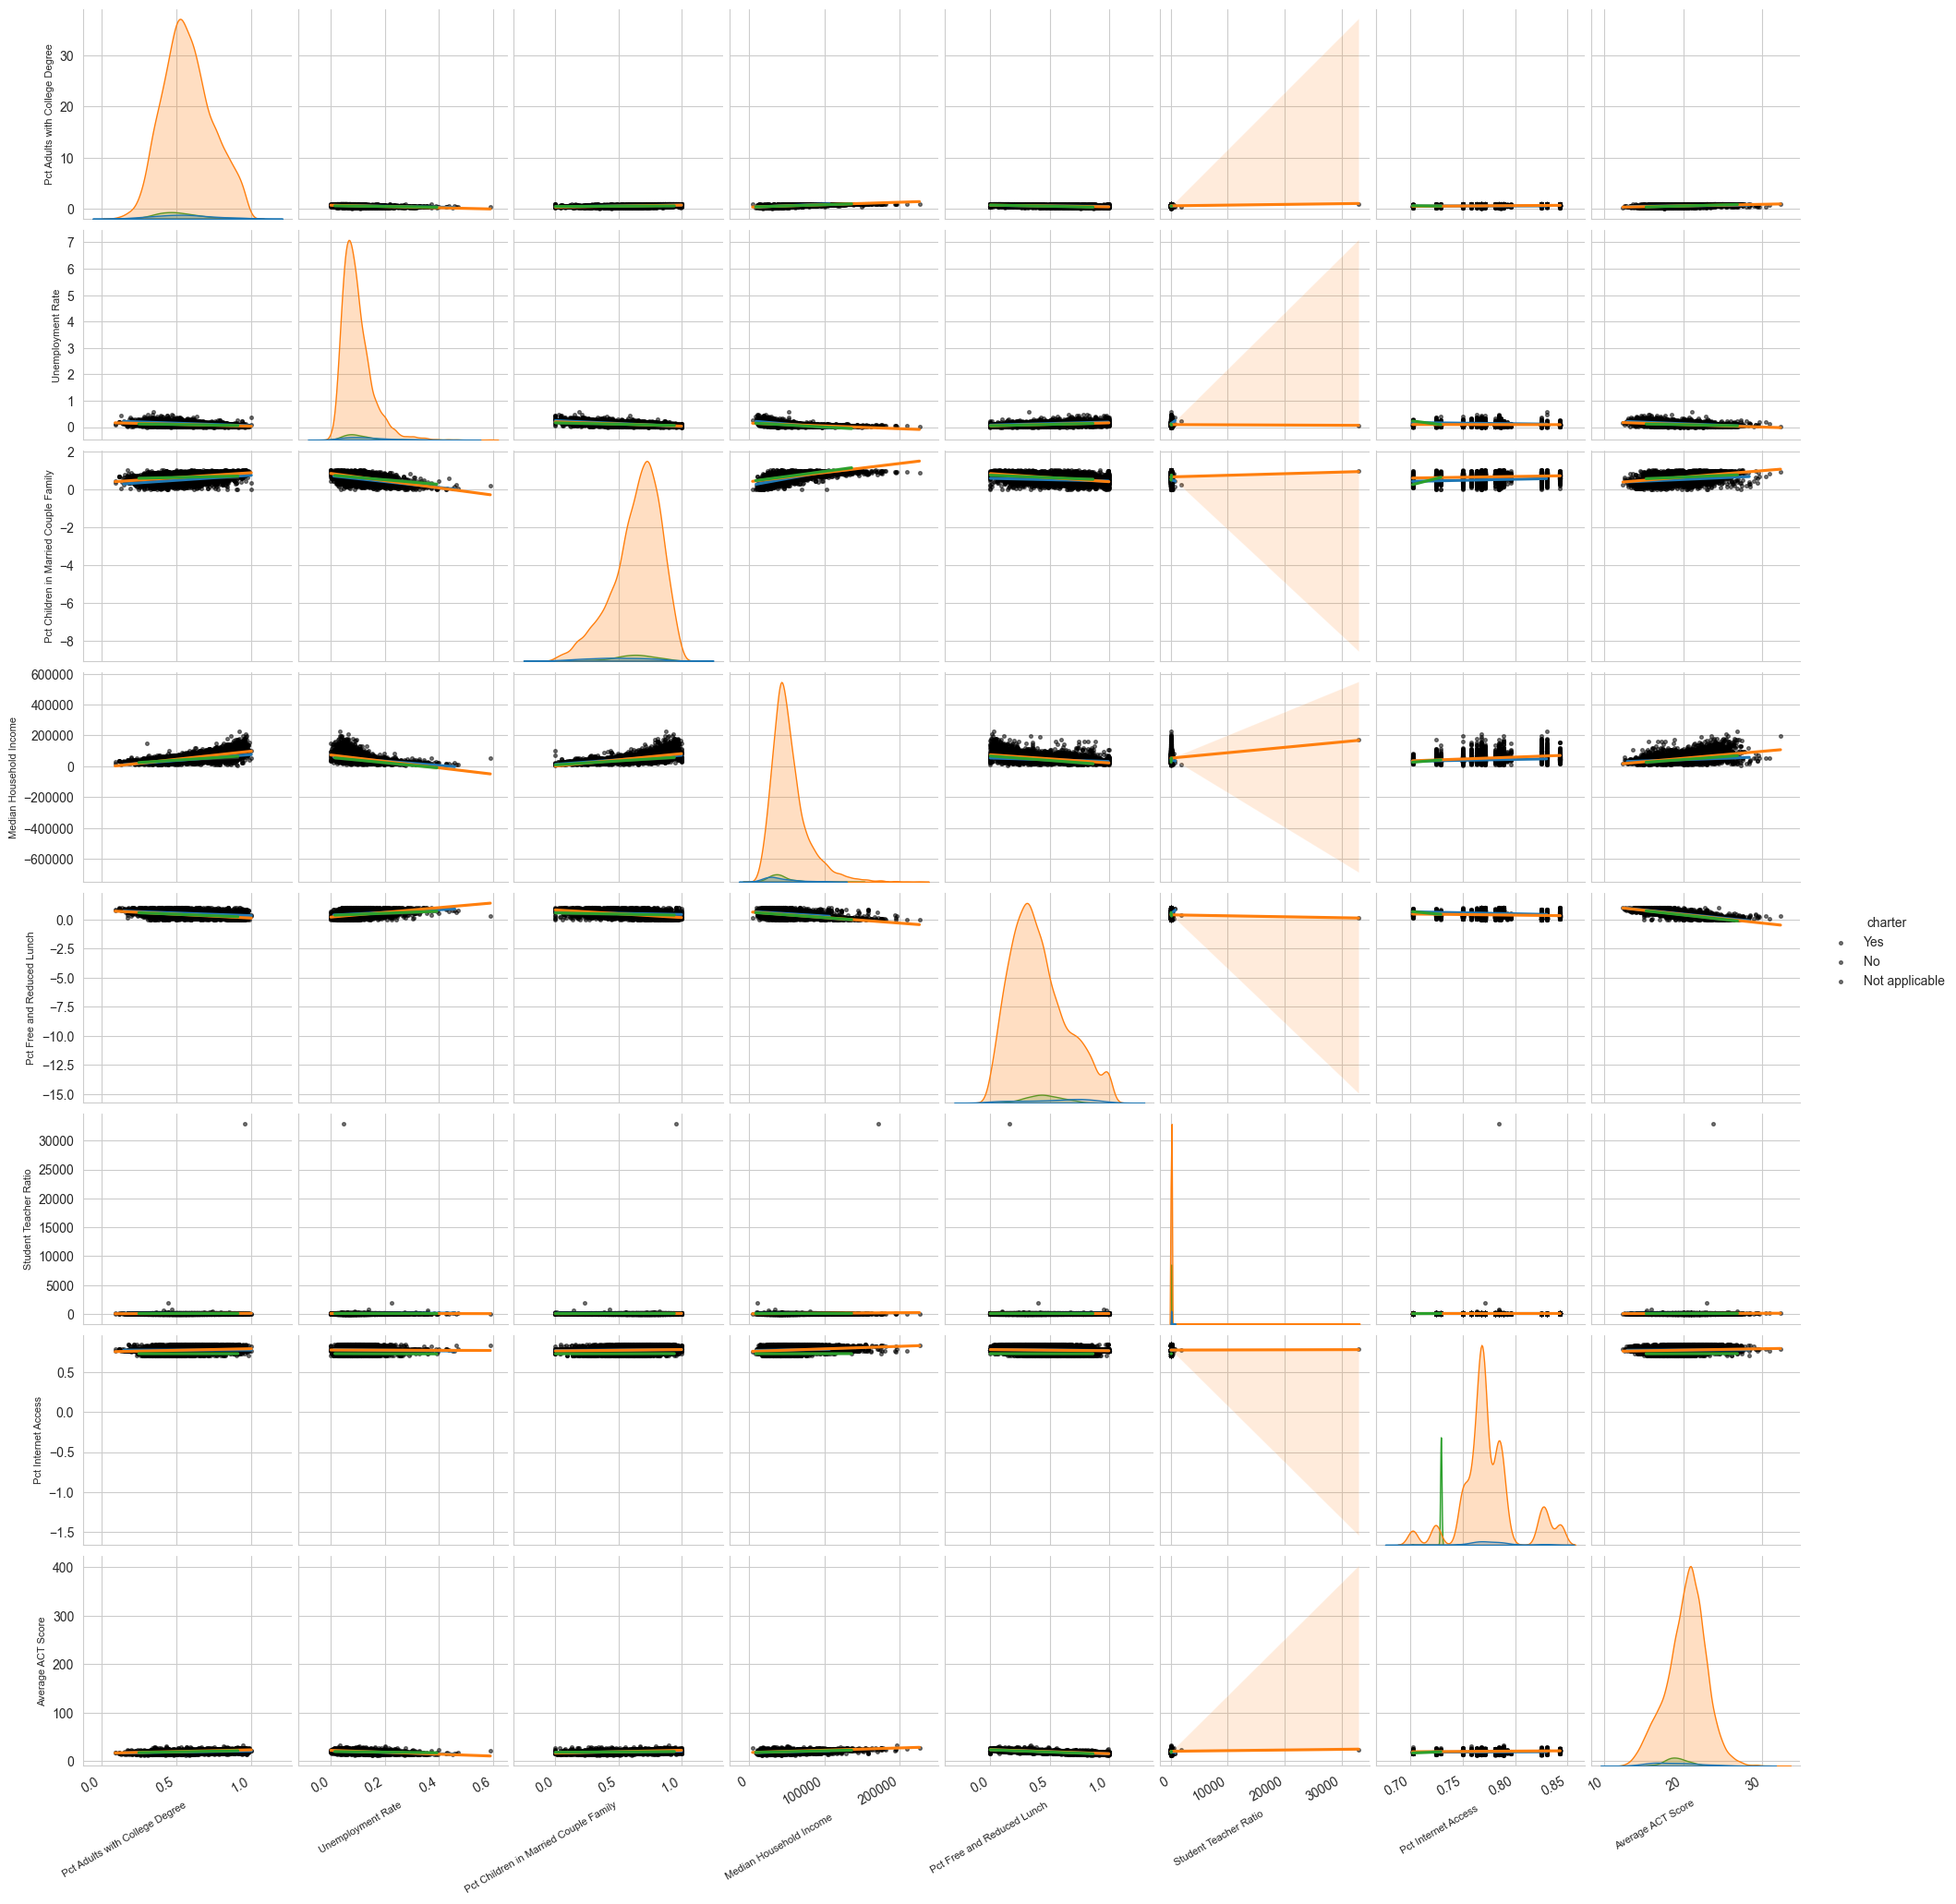

In [76]:
fig = sns.pairplot(
    data=merged_data_school_level_high,
    vars=numerical_predictors + ['average_act'],
    hue='charter',
    kind='reg',
    plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7}},
)

for ax in fig.axes.flat:
    # Use the plot_labels dictionary for more concise labels
    xlabel = ax.get_xlabel()
    if xlabel in plot_labels:
        ax.set_xlabel(plot_labels[xlabel], fontsize=8, rotation=30, ha='right')
    else:
        ax.set_xlabel(xlabel, fontsize=8, rotation=30, ha='right')

    ylabel = ax.get_ylabel()
    if ylabel in plot_labels:
        ax.set_ylabel(plot_labels[ylabel], fontsize=8)
    else:
        ax.set_ylabel(ylabel, fontsize=8)

    if xlabel == 'CT Median Household Income': # Still use original name for this check
        ax.ticklabel_format(
            style='sci', axis='x', scilimits=(0, 0)
        )  # Apply scientific notation


    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

**Interpretation:**

- `percent_lunch` shows strong negative correlation with ``average_act`
    - Schools with more low income students have low low ACT scores.
- `median_income`, `percent_college` have positive correlation with ACT scores.
    - Schools that are around high income and better educated population has good ACT scores.
- `student_teacher_ratio`, `percent_internet_access` have some positive correlation.
- `rate_unemployment` is negatively correlated, which means higher un employment rate lead to lower ACT scores.

- It looks like relationship doesnt show any significant change between charter and non charter schools.

- 8.3 BoxPlots:
    - The below boxplot compares the spread of socioeconomic proportions across schools.

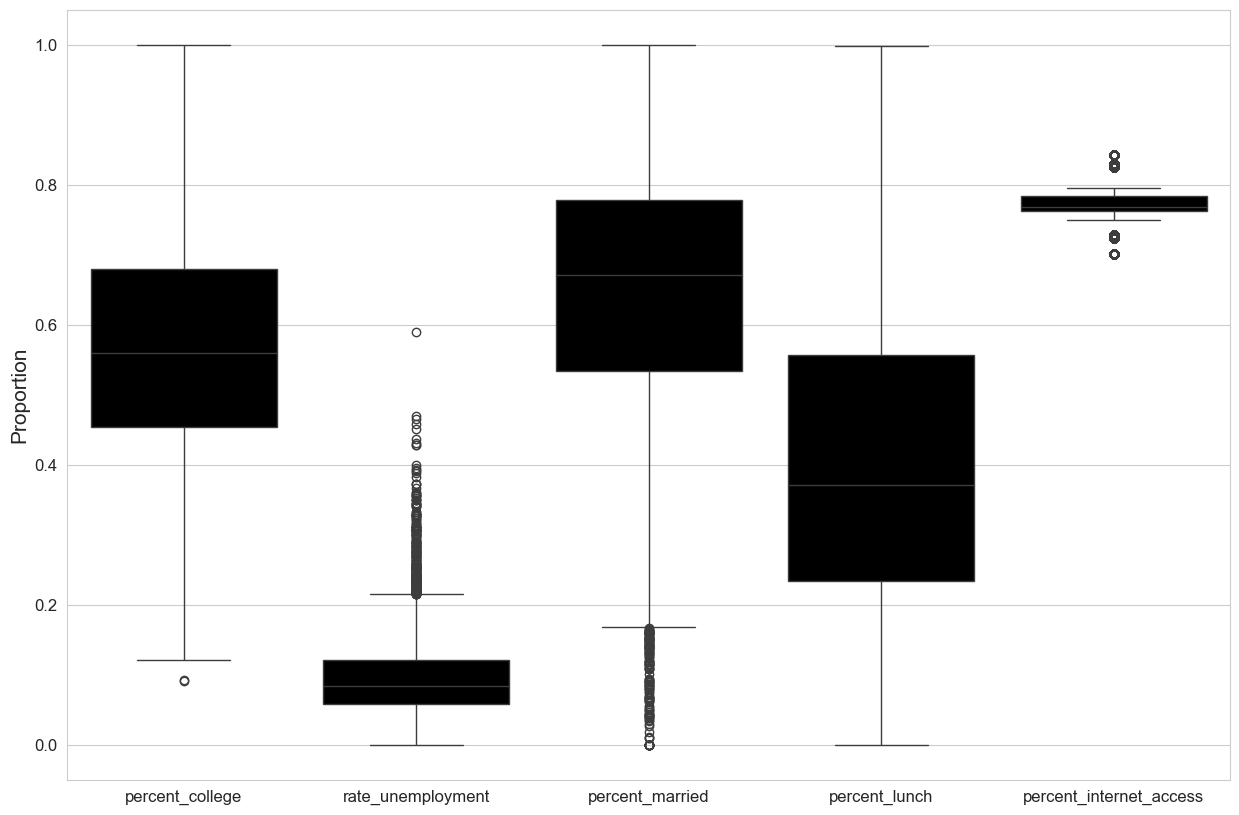

In [77]:
plt.figure(figsize=(15, 10))

fractions = list(numerical_predictors)
fractions.remove('median_income')
fractions.remove('student_teacher_ratio')

sns.boxplot(data=merged_data_school_level_high[fractions], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.tick_params(labelsize=12)

plt.show()

**Interpretation:**
- percent_college: 40% - 70%, high college education with no outliers
- rate_unemployment:  low unemploynment_rate with outliers and the outliers are not far away from the data.
- percent_married: 60%-80%, high marraiage rate with outliers and the outliers are not far away from the data.
- percent_internet_access: It has less variation  and close to 80% indicates most households have internet connectivity.


- The below box plot shows the spread of median household income across high schools.

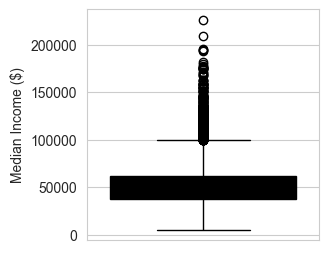

In [78]:
plt.figure(figsize=(3, 3))
sns.boxplot(data=merged_data_school_level_high, y='median_income', color='k')
plt.ylabel('Median Income ($)')
plt.show()

**Interpretation:**
- The median house hold income is around $70K and there are outliers which is predictable with some higher income people.

## 9. Modeling:

- ### 9.1 Single input model:
    - Median income

- Ploting the regression line and the scatter plot to visualize relationship between `median income` and `average ACT score`

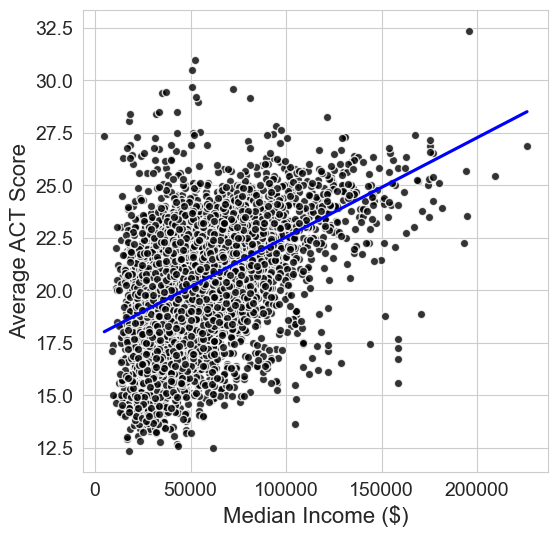

In [79]:
plt.figure(figsize=(6, 6))

sns.regplot(
    data=merged_data_school_level_high,
    x='median_income',
    y='average_act',
    color='blue',
    ci=False,
    scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1},
)

# Add axis labels
plt.xlabel('Median Income ($)', fontsize=16)
plt.ylabel('Average ACT Score', fontsize=16)

# Increase the fontsize of tick labels
plt.tick_params(labelsize=14)

plt.show()

Interpretation:
- Inspected the points around the line which looks linear and supports linear modeling, but noticed that from some median income 100K some average ACT scores are flattened, so will also check for any nonlinearity in upcomming steps.

- Fiting the simple linear regression model of `average ACT` on `median_income`

In [80]:
model_median_income = smf.ols(
    'average_act ~ median_income', data=merged_data_school_level_high
).fit()

# Displaying the fit summary
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1932.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:25:02   Log-Likelihood:                -16044.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8005      0.063    284.388

- The regression model is succesfully fitted which show the relationship between average ACT score and median income

- The R-squared is 0.211 with intercept 17.80 and median_income coefficient as 4.732e-05 and p-value is 0.000 whcih indicates as highly significant.

- The more R-squared is close to 1 the more the model is best fit, in this case it is giving a hint to include other predictors also into the model since R-squared is only 0.211

In [81]:
# Computing predictions `y-hat` for the income only model
y_hat = model_median_income.predict()

In [82]:
# Calculating the RMSE(Square root of MSE) for the income only model
np.sqrt(
    mean_squared_error(merged_data_school_level_high['average_act'], y_hat)
).round(3)

np.float64(2.228)

In [83]:
# Compute the mean absolute error for income only model
mean_absolute_error(merged_data_school_level_high['average_act'], y_hat)

1.7134315735512573

- RMSE is 2.228, which means prediction differs by 2.228 ACT points
- Mean absolute error is 1.7129

- Residual plot for graphical assesment of model fit

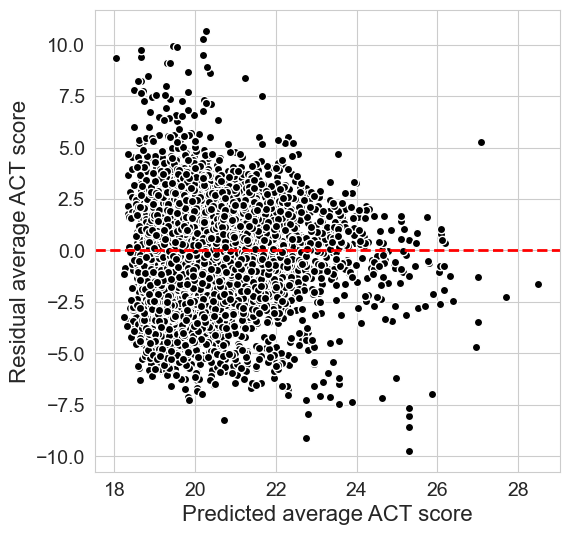

In [41]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', ls='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

- The residual plot shows points scattered around horizontal zero line and suggesting as linear model.
- Since we saw few falttening of dots in the previous plot as when the median income increases few of average ACT score are flattened so therefore going to check for any nonlinearity exists.

- ### 9.2 Quadratic model

    - Ploting the regression curves and the scatter plot

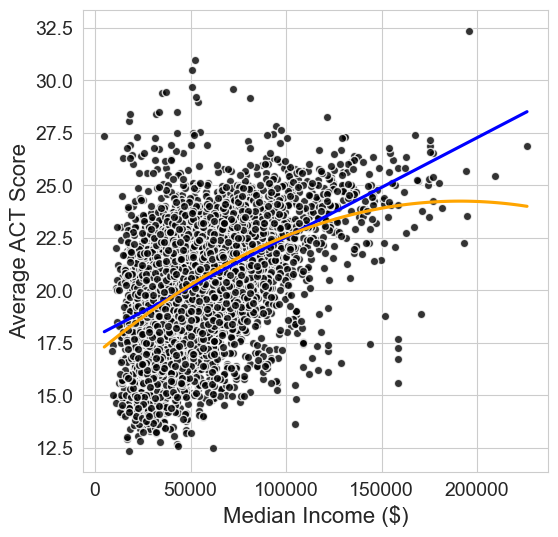

In [84]:
plt.figure(figsize=(6, 6))

sns.regplot(
    data=merged_data_school_level_high,
    x='median_income',
    y='average_act',
    color='blue',
    ci=False,
    scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1},
)

sns.regplot(
    data=merged_data_school_level_high,
    x='median_income',
    y='average_act',
    color='orange',
    ci=False,
    scatter=False,
    order=2,
)

# Add axis labels
plt.xlabel('Median Income ($)', fontsize=16)
plt.ylabel('Average ACT Score', fontsize=16)

# Increase the fontsize of tick labels
plt.tick_params(labelsize=14)

plt.show()

- Looks like the orange curve fits slighly better, in this case ACT score increases with increase in income but level off at higher income. Lets check is there is any non linear relationship.

- Fiting a quadratic linear regression model

In [85]:
model_median_income2 = smf.ols(
    'average_act ~ median_income + I(median_income ** 2)',
    data=merged_data_school_level_high,
).fit()

# Displaying the fit summary
print(model_median_income2.summary())

# Displaying the p-values
print("\np-values: ")
print(model_median_income2.pvalues)

# Comparing the two models using ANOVA
print("\nComparing Linear and Quadratic models: ")
print(anova_lm(model_median_income, model_median_income2))

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1012.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:27:01   Log-Likelihood:                -16008.
No. Observations:                7227   AIC:                         3.202e+04
Df Residuals:                    7224   BIC:                         3.204e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.93

- This model has slightly more R-Squared compared to the previous model, which says the median income square is not so significant which indicates not a significant better fit compared to previous model fit.

- The p-values for both median_income and median income square are quite small, which mean quadratic terms makes a meanigful contribution in explaining the variation of ACT score.
- Small p-values indicates quadratic model slightly better fit than linear model, but not significant enough.

- Compare the quadratic model accuracy to the first order model

In [86]:
print(
    mean_absolute_error(
        merged_data_school_level_high['average_act'], model_median_income2.predict()
    )
)
print(
    mean_absolute_error(
        merged_data_school_level_high['average_act'], model_median_income.predict()
    )
)

1.6975432357878726
1.7134315735512573


- MAE=1.69 show quadratic model has very small improvement compared to linear model (MAE=1.713)

- ### 9.3 Multiple linear regression
    - Fiting the multiple linear regression model using all socioeconomic variables as predictors that are already considered along with new predictors `student_teacher_ratio` and `percent_internet_access`

In [87]:
model = smf.ols(
    'average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch + student_teacher_ratio + percent_internet_access',
    data=merged_data_school_level_high,
).fit()

# Displaying the fit summary
print(model.summary())

# Computing predictions `y-hat` for the multiple regression model
y_hat = model.predict()

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     1758.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:27:13   Log-Likelihood:                -13305.
No. Observations:                7227   AIC:                         2.663e+04
Df Residuals:                    7219   BIC:                         2.668e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

- Successfully Fitted multiple linear regression with sociaeconomic predictors `rate_unemployment`, `precent_college`, `precent_married`, `median_income`, `precent_lunch`, `student_teacher_ratio` and `percent_internet_access`

- For the multiple linear regression that is discussed in the class room with sociaeconomic predictors `rate_unemployment`, `precent_college`, `precent_married`, `median_income`, `precent_lunch`, the R-Squared is `0.628` which is a significant improvement in model fit compared to `income` only `linear` and `quadratic` models.

- In this project we have added two more new predictors which are `student_teacher_ratio` and `percent_internet_access` along with the existing ones and R-squared is `0.630` which made some slight increase.

- Cofficient on `percent_income` and `median_income` has relativily large P values which indicates they are not statistically significant. so we might not need all predictors in single model

- Residual plot for graphical assesment of model fit

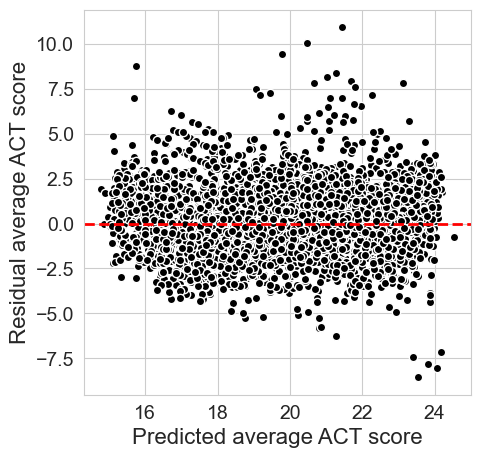

In [88]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

- Relatively no structure which unlikely to improve model by making transformations of input variables we used.

- Mean absolute error:

In [89]:
mean_absolute_error(merged_data_school_level_high['average_act'], model.predict())

1.1372034023880797

- MAE is less than individual predictor models
- MAE(1.13) is also slightly less than multilinear model that is discussed in class room(MAE=1.14) on predictors `rate_unemployment`, `precent_college`, `precent_married`, `median_income`, `precent_lunch`

- Fiting a reduced model with the significant predictors
    - we are not including unsignificant predictors `median_income`, `percent_married` and `student_teacher_ratio`

In [90]:
model_reduced = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch + percent_internet_access',
    data=merged_data_school_level_high,
).fit()

# Displaying the fit summary
print(model_reduced.summary())

y_hat = model_reduced.predict()

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     3075.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:27:24   Log-Likelihood:                -13307.
No. Observations:                7227   AIC:                         2.662e+04
Df Residuals:                    7222   BIC:                         2.666e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

- Successfully fitted model with significant predictors like `rate_unemployment`, `percent_college`, `percent_lunch`

- All three variables have statistically significant coefficients.
- R-squared remain same and the `rate_unemployment`, `percent_college`,`percent_lunch`, `percent_internet_access` predictors are the accurate predictors with statistical significance.

- Residual plot for graphical assesment of model fit

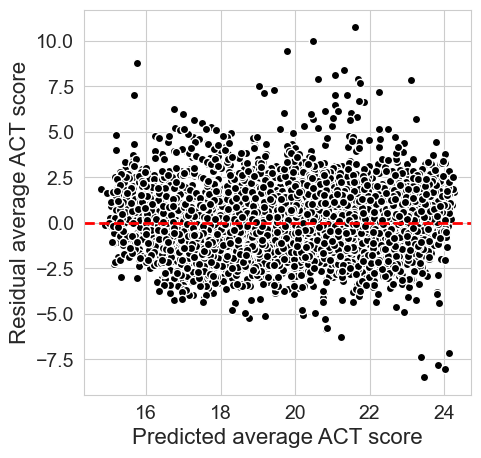

In [91]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

- The residual plot shows the points are scattered around the zero line which shows model fits the data well.

- Computing the mean absolute error

In [92]:
mae_full = mean_absolute_error(
    merged_data_school_level_high['average_act'], model.predict()
)
mae_reduced = mean_absolute_error(
    merged_data_school_level_high['average_act'], model_reduced.predict()
)
print("M.A.E for full predictor Multiple linear regression: ", mae_full)
print("\nM.A.E for reduced predictor Multiple linear regression: ", mae_reduced)

M.A.E for full predictor Multiple linear regression:  1.1372034023880797

M.A.E for reduced predictor Multiple linear regression:  1.1381410010216155


- M.A.E is `1.13` which show Multiple linear regression with significant predictors is same as full predictor Multiple linear regression and is better than single linear regression models, favoring significant predictor model

- Using an ANOVA to test the significance of difference between models:

In [93]:
r2_full = model.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame(
    {
        'Mean Absolute Error': [mae_full, mae_reduced],
        'R-squared': [r2_full, r2_reduced],
    },
    index=['Full Model', 'Reduced Model'],
).round(4)

# Comparing the two models using ANOVA
anova_lm(model_reduced, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7222.0,16820.687866,0.0,NaN,NaN,NaN
1,7219.0,16811.621566,3.0,9.0663,1.297706,0.273327


- ### 9.4 Scaling

- Scaling the predictor variables in the reduced model to have `mean 0` and `standard deviation 1` and adding them to the data frame

In [94]:
# Defining which predictors to standardize
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_lunch',
    'percent_internet_access',
]

# Creating names for standardized columns
scaled_column = [var + '_normalized' for var in predictor_variables]
print(scaled_column)

# Fitting StandardScaler on selected predictors
scaler = StandardScaler().fit(merged_data_school_level_high[predictor_variables])

# Applying the scaler abd writing standardized columns into DataFrame merged_data_school_level_high
merged_data_school_level_high[scaled_column] = scaler.transform(
    merged_data_school_level_high[predictor_variables]
)

# Checking the mean and standard deviation of the transformed data
merged_data_school_level_high[scaled_column].agg(['mean', 'std']).round(3)

['rate_unemployment_normalized', 'percent_college_normalized', 'percent_lunch_normalized', 'percent_internet_access_normalized']


,rate_unemployment_normalized,percent_college_normalized,percent_lunch_normalized,percent_internet_access_normalized
mean,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0


- It keeps both origibnal and scaled versions in a DataFrame
- Standardized values exists in new columns that ends with `_normalized`
- Mean is 0 and standard deviation is 1 which confirms scaling

- Fiting the multiple linear regression model with the normalized predictors

In [95]:
model_normalized = smf.ols(
    'average_act ~ rate_unemployment_normalized + percent_college_normalized + percent_lunch_normalized + percent_internet_access_normalized',
    data=merged_data_school_level_high,
).fit()

# Printing summary
print(model_normalized.summary())


# Comparing the accuracy between the original and normalized models
mae_normalized = mean_absolute_error(
    merged_data_school_level_high['average_act'], model_normalized.predict()
)
mae_reduced = mean_absolute_error(
    merged_data_school_level_high['average_act'], model_reduced.predict()
)

r2_normalized = model_normalized.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame(
    {
        'Mean Absolute Error': [mae_normalized, mae_reduced],
        'R-squared': [r2_normalized, r2_reduced],
    },
    index=['Normalized Model', 'Reduced Model'],
).round(4)

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     3075.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:27:45   Log-Likelihood:                -13307.
No. Observations:                7227   AIC:                         2.662e+04
Df Residuals:                    7222   BIC:                         2.666e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

,Mean Absolute Error,R-squared
Normalized Model,1.1381,0.63
Reduced Model,1.1381,0.63


- Percent of students at school receiving free or reduced price lunch is the strongest predictor in the analysis.
- Noticed that MAE and R-Squared remain same which means scalling doesn't change R-Squared and Mean Absolute Error value.

### 10. Conclusion:
- The R-squared value of 0.63 indicates that approximately 63% of the variance in average ACT scores can be explained by the predictors included in the reduced multiple regression model.
- **Percent of students receiving free or reduced price lunch** is a strong negative predictor, meaning that schools with a higher percentage of students receiving free or reduced price lunch tend to have lower average ACT scores. This suggests a strong association between socioeconomic disadvantage and ACT performance.
- **Unemployment rate** shows a statistically significant negative relationship with ACT scores; higher unemployment rates in the community are associated with lower average ACT scores.
- **Percent of internet access** has a statistically significant positive relationship with ACT scores; states with a higher percentage of households with internet access tend to have schools with higher average ACT scores.
- **Percent of adults with a college degree** is positively correlated with ACT scores; communities with a higher percentage of college-educated adults are associated with higher average ACT scores in nearby schools.

- The analysis explored the relationship between median household income and ACT scores, finding that while a quadratic term showed a statistically significant improvement over a simple linear model (based on ANOVA), the practical gain in predictive power (measured by R-squared and MAE) was minimal. This suggests the relationship is predominantly linear, with some leveling off at higher income levels.
- Comparing the full multiple regression model (including `percent_married`, `median_income`, and `student_teacher_ratio`) to a reduced model (excluding these non-significant predictors) revealed that the reduced model performs comparably in terms of overall fit (similar R-squared and MAE). The ANOVA confirmed that the excluded predictors did not contribute statistically significant explanatory power when the other variables were already in the model, supporting the use of the more concise reduced model.
